# Librerías

In [1]:
import numpy as np
import os
import pandas as pd
import math

from tools.compare_functions import load_solutions, get_pareto_front, get_styled_table, classify_solutions
from tools import create_distances
from tools.delete_dominated_solutions import delete_dominated_solutions
from tools.grasp_multiprocessing_MAB_LS_2 import multi_GRASP_Bandit
from tools.fine_tuning import contar_soluciones_en_pareto
from tools.obtain_metrics import calcular_coverage_pareto

import statistics
import multiprocessing
from tqdm import tqdm
from IPython.display import display, HTML
import glob


# Datos

In [32]:
archive = "WorkSpace 1000_50_5"
k=5
m=50
context_size=3
alpha=0.3
betha=1
learning_rate=0.1
temperature=1.5

paralelizando las 220 instancias, a 2.1 segundos por cada una de las 100 iteraciones, cada instancia ejecutada 100 veces son 0.95.

Quiero que en total dure 2.1 seg, así que 100*2.1/0.95 mas o menos 220 iteraciones

In [72]:
archive = "WorkSpace 1000_50_10"
k=10
m=50
context_size=3
alpha=0.3
betha=0.1
learning_rate=0.1
temperature=1.5

paralelizando las 220 instancias, a 3.5 seg cada una de las 100 iteraciones. cada instancia ejecutada 100 veces sería 1.59 seg por instancia. Quiero que dure 2.8 segu, así que 100*2.8/1.59=176 iteraciones

# Preparar los datos

In [18]:
create_distances.create_distances(archive)

# Función multiproceso

In [19]:
def ejecutar_con_pool(archive, k, m, context_size, alpha, betha, learning_rate, temperature):
    """
    Ejecuta la función multi_GRASP en paralelo usando multiprocessing.Pool.

    Args:
        archive: El parámetro 'archive' para multi_GRASP.
        k: El parámetro 'k' para multi_GRASP.
        m: El parámetro 'm' para multi_GRASP.
        alpha: El parámetro 'alpha' para multi_GRASP.
    """
    num_corridas = 220 # Número de veces que quieres ejecutar multi_GRASP

    # Crear una lista de tuplas de argumentos.
    # Cada tupla en esta lista será pasada como *args a una llamada de multi_GRASP.
    # Como queremos ejecutar la misma función 10 veces con los MISMOS parámetros,
    # creamos una lista que contiene 10 veces la misma tupla de argumentos.

    lista_de_argumentos = []
    for i in range(num_corridas):
        # Ahora, 'i' es el corrida_id para cada ejecución
        lista_de_argumentos.append((archive, k, m, context_size, alpha, betha, learning_rate, temperature, i+1))

    # Usando Pool con 'with' asegura que el pool se cierre correctamente
    # Puedes especificar el número de procesos en Pool(processes=N).
    # Si no lo especificas, usa multiprocessing.cpu_count()
    with multiprocessing.Pool() as pool:
        # pool.starmap() es ideal para aplicar una función que toma múltiples
        # argumentos (desempaquetados de una tupla) a cada elemento
        # (que es una tupla de argumentos) de un iterable (lista_de_argumentos).
        pool.starmap(multi_GRASP_Bandit, lista_de_argumentos)


# Ejecución GRASP

In [ ]:
for i in tqdm(range(176), desc="Ejecutando GRASP"):
    ejecutar_con_pool(archive, k, m, context_size, alpha, betha, learning_rate, temperature)

## Coverage

In [73]:
vector_coverage=calcular_coverage_pareto(archive = archive, total_corridas=40)

✅ Frente de Pareto cargado desde 'Pareto_front/WorkSpace 1000_50_10.csv'. Contiene 47 soluciones.


In [74]:
print(f"\nCoverage Promedio: {statistics.mean(vector_coverage):.4f}")


Coverage Promedio: 0.3628


## Soluciones medias

In [75]:
vector_de_conteos = contar_soluciones_en_pareto(archive, total_corridas=40)

✅ Frente de Pareto cargado desde 'Pareto_front/WorkSpace 1000_50_10.csv'. Contiene 47 soluciones.


In [76]:
print(f"\nCoverage Promedio: {statistics.mean(vector_de_conteos):.4f}")


Coverage Promedio: 10.9500


## Gráfica soluciones medias

In [9]:
import matplotlib.pyplot as plt

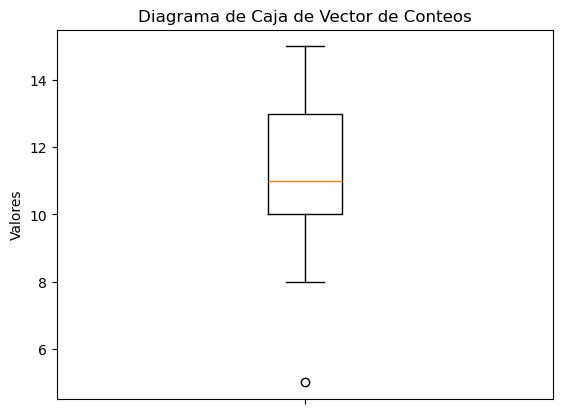

In [56]:
# 2. Crear la figura y los ejes para el gráfico
fig, ax = plt.subplots()

# 3. Generar el boxplot
ax.boxplot(vector_de_conteos)

# 4. Añadir títulos (opcional pero recomendado)
ax.set_title('Diagrama de Caja de Vector de Conteos')
ax.set_ylabel('Valores')
ax.set_xticklabels(['']) # Oculta la etiqueta del eje x si no es necesaria

# 5. Mostrar el gráfico
plt.show()

## Porcentaje de espacio explorado

In [77]:
ruta_pareto=f"Pareto_front/{archive}.csv"

In [78]:
vector_de_conteos = contar_soluciones_en_pareto(archive, total_corridas=40)

✅ Frente de Pareto cargado desde 'Pareto_front/WorkSpace 1000_50_10.csv'. Contiene 47 soluciones.


In [79]:
df = pd.read_csv(ruta_pareto)
total_soluciones= len(df)
print(f"Total de soluciones: {total_soluciones}")
total_combinaciones= math.comb(m, k)
print(f"total de combinaciones: {total_combinaciones}")

Total de soluciones: 47
total de combinaciones: 10272278170


In [80]:
# Calcular el porcentaje de soluciones encontradas
porcentaje_soluciones_encontradas=[v/total_soluciones*100 for v in vector_de_conteos]

In [ ]:
print(f"Porcentaje medio de soluciones: {statistics.mean(porcentaje_soluciones_encontradas):.4f} %")

# Juntar soluciones en un único archivo y borrar las que no pertenezcan al frente de pareto

In [24]:
folder_solutions=f"Solutions/Multiprocessing/{archive}/"

In [25]:
file_pattern = os.path.join(folder_solutions, f"{archive}_#*.csv")

# Obtiene una lista de todos los archivos que coinciden con el patrón
solution_files = glob.glob(file_pattern)

if not solution_files:
    print(f"No se encontraron archivos de solución para unificar en {folder_solutions} con el patrón '{archive}_#*.csv'.")


all_solutions_df = pd.DataFrame()

# Lee cada archivo y concaténalos
for file_path in solution_files:
    try:
        df_temp = pd.read_csv(file_path)
        all_solutions_df = pd.concat([all_solutions_df, df_temp], ignore_index=True)
    except Exception as e:
        print(f"Error al leer el archivo {file_path}: {e}")

if all_solutions_df.empty:
    print("No se pudo leer ninguna solución. El DataFrame unificado está vacío.")

all_solutions_df.drop_duplicates(subset=['solution'], inplace=True)

# Guarda el DataFrame unificado
try:
    final_unified_route = os.path.join(folder_solutions, f"{archive}.csv")

    # Verifica si el archivo unificado ya existe
    if os.path.exists(final_unified_route):
        print(f"El archivo unificado {final_unified_route} ya existe. Cargando soluciones existentes para añadir las nuevas.")
        try:
            # Carga las soluciones existentes
            df_existing_solutions = pd.read_csv(final_unified_route)
            
            # Concatena las soluciones existentes con las nuevas soluciones leídas de los archivos individuales
            # all_solutions_df ya contiene las soluciones de los archivos _#i.csv
            all_solutions_df = pd.concat([df_existing_solutions, all_solutions_df], ignore_index=True)
            
            print("Aplicando lógica de deduplicación y dominancia al conjunto combinado...")
            # Aplica la lógica de deduplicación. Si 'solution' es tu identificador único:
            all_solutions_df.drop_duplicates(subset=['solution'], inplace=True) 

        except pd.errors.EmptyDataError:
            print(f"El archivo {final_unified_route} existe pero está vacío. Creando uno nuevo.")
            # Si el archivo existe pero está vacío, all_solutions_df ya tiene los datos nuevos.
        except Exception as e:
            print(f"Error al cargar el archivo existente {final_unified_route}: {e}. Se intentará guardar solo las soluciones nuevas.")
            # En caso de error, procedemos con lo que ya está en all_solutions_df
            
    # Guarda el DataFrame unificado (sea el nuevo o el combinado)
    all_solutions_df.to_csv(final_unified_route, index=False)
    print(f"Todas las soluciones se han unificado y guardado en: {final_unified_route}")

    # Opcional: Eliminar los archivos individuales después de la unificación exitosa
    for file_path in solution_files:
        os.remove(file_path)
    print("Archivos individuales eliminados.")

except Exception as e:
    print(f"Error general al gestionar el archivo unificado {final_unified_route}: {e}")


delete_dominated_solutions(archive)

Todas las soluciones se han unificado y guardado en: Solutions/Multiprocessing/WorkSpace 1000_50_5/WorkSpace 1000_50_5.csv
Archivos individuales eliminados.
Soluciones no dominadas:
                solution          f1   f2   f3
0     [3, 9, 12, 27, 29]  442.764046  233  103
1    [4, 14, 27, 29, 47]  377.005305  284  202
2    [2, 17, 19, 23, 29]  458.802790  209   22
3   [13, 20, 23, 29, 49]  415.120464  233  129
4    [7, 14, 23, 29, 49]  415.120464  242  120
5     [1, 4, 14, 27, 29]  379.969736  259  160
6   [14, 23, 29, 45, 49]  412.137113  253  147
7     [3, 7, 12, 27, 29]  442.764046  229  104
8    [4, 14, 27, 29, 46]  377.005305  281  210
9   [15, 20, 23, 30, 49]  422.413305  237  127
10    [2, 8, 11, 27, 29]  481.133038  203    6
11    [3, 9, 13, 27, 29]  433.416659  243  113
12   [3, 12, 15, 27, 30]  450.699456  227   83
13  [14, 23, 28, 33, 49]  438.262478  249   97
14  [13, 23, 28, 33, 49]  423.161908  250  112
15  [13, 23, 29, 45, 49]  412.506970  247  148
16  [14, 20, 23, 29

# Comparar soluciones con el pareto front

In [26]:
ruta_solution="Solutions/Multiprocessing/"+archive+"/"+archive+".csv"
ruta_pareto=f"Pareto_front/{archive}.txt"
df_csv_full, df_csv_obj, df_txt = load_solutions(ruta_solution, ruta_pareto)

In [27]:
# Unir y encontrar frente de Pareto
all_solutions = np.vstack([df_csv_obj.values, df_txt.values])
pareto_mask = get_pareto_front(all_solutions)
pareto_solutions = all_solutions[pareto_mask]

# Arrays para detección de comunes
csv_array = df_csv_obj.values
txt_array = df_txt.values

# Clasificar
colors_csv = classify_solutions(df_csv_obj, pareto_solutions, txt_array)
colors_txt = classify_solutions(df_txt, pareto_solutions, csv_array)

# Mostrar
html_csv = get_styled_table(df_csv_full, colors_csv)
html_txt = get_styled_table(df_txt, colors_txt)

# Mostrar lado a lado con HTML
display(HTML(f"""
<div style="display: flex; gap: 30px;">
  <div style="flex: 1;">
    <h3>Soluciones CSV (con ID)</h3>
    {html_csv}
  </div>
  <div style="flex: 1;">
    <h3>Soluciones TXT</h3>
    {html_txt}
  </div>
</div>
"""))


,solution,f1,f2,f3
0,"[3, 9, 12, 27, 29]",442.764046,233,103
1,"[4, 14, 27, 29, 47]",377.005305,284,202
2,"[2, 17, 19, 23, 29]",458.802790,209,22
3,"[13, 20, 23, 29, 49]",415.120464,233,129
4,"[7, 14, 23, 29, 49]",415.120464,242,120
5,"[1, 4, 14, 27, 29]",379.969736,259,160
6,"[14, 23, 29, 45, 49]",412.137113,253,147
7,"[3, 7, 12, 27, 29]",442.764046,229,104
8,"[4, 14, 27, 29, 46]",377.005305,281,210
9,"[15, 20, 23, 30, 49]",422.413305,237,127
